# <center> АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные.

Нам предстоит решить бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

Мы должны убедиться, что A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?

Компания предлагает следующие варианты туров:
* Таиланд — 100 000 рублей;
* Турция — 60 000 рублей;
* Мальдивы — 200 000 рублей;
* Санкт-Петербург — 10 000 рублей;
* Камчатка — 150 000 рублей.

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [1]:
import pandas as pd

data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Наша таблица представлена следующими полями:

|feature|description|
|-|-|
|`user_id`|идентификатор пользователя, зашедшего на сайт|
|`data`|дата посещения сайта|
|`group`|группа теста (контрольная — А или тестовая — B)|
|`purchase`|признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)|
|`price`|цена купленного тура (если покупка не состоялась, цена равна 0)|

---
## Анализ структуры данных. Предобработка

Посмотрим, есть ли пропуски.

In [2]:
data.isna().sum()

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64

Пропусков нет, однако нам нужно перевести столбец с информацией о дате события (date) в формат datetime.

In [3]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


Убедимся в одинаковой длительности проведения A/B-тестирования в каждой из групп.

In [5]:
group_A_begin_time = data.query("group == 'A'")['date'].min()
group_A_end_time = data.query("group == 'A'")['date'].max()

group_B_begin_time = data.query("group == 'B'")['date'].min()
group_B_end_time = data.query("group == 'B'")['date'].max()

print(f"""
Дата начала и конца тестирования в группе А
Начало: {group_A_begin_time}
Конец:  {group_A_end_time}""")
print(f"""
Дата начала и конца тестирования в группе B
Начало: {group_B_begin_time}
Конец:  {group_B_end_time}""")


Дата начала и конца тестирования в группе А
Начало: 2021-01-02 00:00:00
Конец:  2021-01-24 00:00:00

Дата начала и конца тестирования в группе B
Начало: 2021-01-02 00:00:00
Конец:  2021-01-24 00:00:00


Кажется, тест сошелся по времени для обеих групп: 23 дня.

Проверим теперь, есть ли пользователи, которые в процессе A/B-теста попали в обе группы.

In [5]:
# Группируем данные по 'user_id' и считаем количество уникальных значений по столбцу 'group'
group_counts = data.groupby('user_id')['group'].nunique()

# Выбираем id пользователей, у которых количество уникальных значений равно двум (и 'A', и 'B')
users_with_both_groups = group_counts[group_counts == 2].index

# Фильтруем исходный DataFrame, оставляя только пользователей, которые имеют записи и с лейблом 'A', и с лейблом 'B'
result_df = data[data['user_id'].isin(users_with_both_groups)]

print(result_df.shape)
result_df.sort_values('user_id').head(6)

(3790, 5)


,user_id,date,group,purchase,price
207211,630320,2021-01-07,A,0,0
255753,630320,2021-01-12,B,0,0
39852,630805,2021-01-22,A,0,0
73599,630805,2021-01-12,B,0,0
213377,630871,2021-01-08,A,0,0
18596,630871,2021-01-03,B,0,0


Кажется, код отработал верно. Исключим пользователей, оказавшихся в обеих группах.

In [6]:
indexes_to_drop = list(result_df.index)
print(data.shape)
data = data.drop(indexes_to_drop)
print(data.shape)

(294478, 5)
(290688, 5)


---
## Первичный анализ

Рассчитаем вспомогательные показатели для контрольной и тестовой групп:
* количество посещений сайта;
* суммарное количество совершённых покупок;
* сумма всех покупок.

Сделаем промежуточные выводы по построенной таблице.

In [7]:
grouped_data = data.groupby(['group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'user_id': 'users_count'}).reset_index()

grouped_data

,group,users_count,purchase,price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Количество посещений обоих вариантов посадочной страницы вполне сопоставимо. Можно говорить о сбалансированности выборок.

В каждой из групп рассчитаем ключевые показатели:
* конверсия;
* средний чек.

In [8]:
grouped_data['total_conversion'] = grouped_data['purchase'] / grouped_data['users_count'] * 100
grouped_data['total_mean_check'] = grouped_data['price'] / grouped_data['purchase']
grouped_data

,group,users_count,purchase,price,total_conversion,total_mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


На первый взгляд, вариант `А` эффективнее варианта `B` по показателю конверсии, а вариант `B` — по среднему чеку.

Сравним варианты их по покупательской способности каждого из туров. Для этого построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура.

In [9]:
purchasing_power = data.groupby(['group', 'price']).agg({'purchase': 'sum'})
purchasing_power.T

group         A                                         B                \
price    0      10000  60000  100000 150000 200000 0      10000  60000    
purchase      0   5182   5271   1832   3478   1724      0   5201   1730   

group                          
price    100000 150000 200000  
purchase   5227   3438   1694

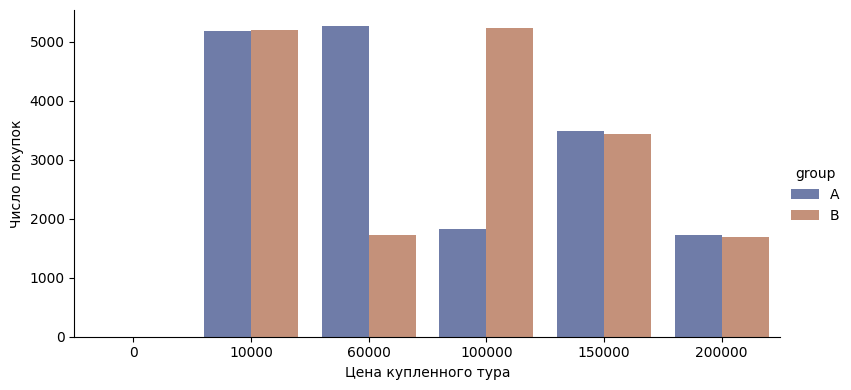

In [10]:
import seaborn as sns

graph = sns.catplot(
    data=purchasing_power.reset_index(), kind="bar",
    x="price", y="purchase", hue="group", palette="dark", alpha=.6, height=4, aspect=2
)
graph.set_axis_labels("Цена купленного тура", "Число покупок");

По трем турам из пяти наблюдается почти равная покупательская способность участников обеих групп, но по турам за 60K и 100К имеется практически симметричное преимущество у `A` над `В` и наоборот.

---
## Анализ стабилизации метрик

Сгруппируем данные по дате и группе тестирования и построим таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислим ежедневные показатели:
* количество посещений страницы;
* количество покупок;
* сумму покупок.

Добавим в таблицу также информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

In [11]:
daily_data = data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})

daily_data['conversion'] = daily_data['purchase'] / daily_data['users_count'] * 100
daily_data['mean_check'] = daily_data['price'] / daily_data['purchase']

print('Shape:', daily_data.shape)
daily_data.head()

Shape: (46, 7)


,date,group,users_count,purchase,price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


Рассчитаем кумулятивные показатели:
* кумулятивное количество посещений страницы;
* кумулятивное количество покупок;
* кумулятивную сумму покупок.

На основе полученных кумулятивных показателей вычислим кумулятивную конверсию и кумулятивный средний чек.

In [12]:
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase'].cumsum()
daily_data['cum_price'] = daily_data.groupby(['group'])['price'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_purchase']/daily_data['cum_users_count'] * 100
daily_data['cum_mean_check'] = daily_data['cum_price']/daily_data['cum_purchase']
daily_data.head(6)

,date,group,users_count,purchase,price,conversion,mean_check,cum_users_count,cum_purchase,cum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
5,2021-01-04,B,6536,764,68030000,11.689106,89044.502618,16016,1863,163650000,11.632118,87842.190016


Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням.

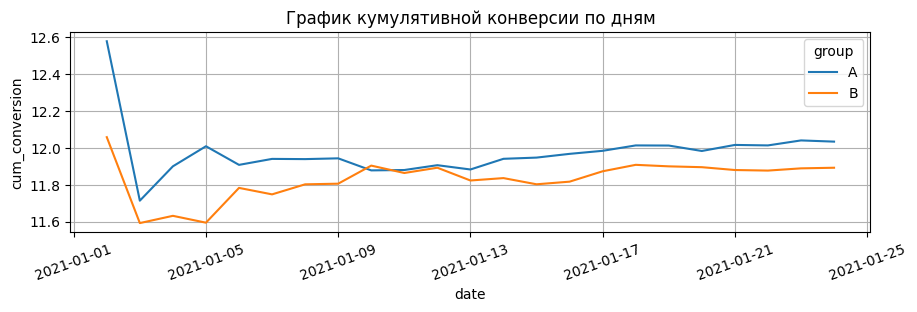

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 2))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 20)
# задаём отображение сетки
ax.grid(True);

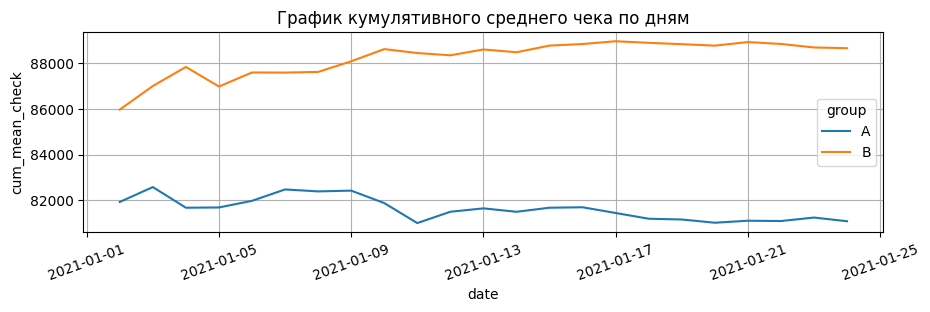

In [14]:
fig = plt.figure(figsize=(8, 2))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивного среднего чека по дням')
ax.xaxis.set_tick_params(rotation = 20)
ax.grid(True);

В целом, можно утверждать, что A/B-тест завершён (хотя, наверное, продление на неделю не было бы лишним): значения метрик во времени стабилизировались окончательно, на мой взгляд, примерно с 17-18 числел января. По кумулятивной конверсии группа `А` выглядит более предпочтительной, однако по показателю кумулятивного среднего чека безоговорочное преимущество у группы `В`.

---
## Статистический анализ

Сформулируем статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберем статистический тест для их проверки.

Во-первых, нам необходимо оценить разницу конверсий — есть ли она вообще. Мы воспользуемся z-тестом для проверки следующей пары гипотез:
* Нулевая (будет задавать отсутствие эффекта): конверсии в группах `A` и `B` равны. $$H_0: p_a = p_b$$
* Альтернативная (будет задавать наличие эффекта): конверсии в группах `A` и `B` не равны. $$H_1: p_a \neq p_b$$

Если далее возникнет необходимость уточнить различие конверсий — может ли она быть лучше в одной группе, чем в другой? — мы переформулируем наши гипотезы соответствующим образом.

Во-вторых, нужно оценить разницу в среднем чеке между группами. Здесь мы проверим распределения на нормальность и, в зависимости от результата, воспользуемся соответствующим тестом. Ну а проверять мы будем следующие пары гипотез:
- Для параметрического теста:
    * Нулевая: средний чек в группах `A` и `B` равны. $$H_0: \mu_a = \mu_b$$
    * Альтернативная: средний чек в группах `A` и `B` не равны. $$H_1: \mu_a \neq \mu_b$$
- Для непараметрического теста:
    * Нулевая: распределение, лежащее в основе среднего чека в группе `A`, идентично распределению, лежащему в основе среднего чека в группе `B`. $$H_0: F_a(u) = F_b(u)$$
    * Альтернативная: распределение, лежащее в основе среднего чека в группе `А`, отлично от распределения, лежащего в основе среднего чека в группе `B`: $$H_1: F_a(u) \neq F_b(u)$$

Также, возможно, мы уточним наши гипотезы, если в этом появится нужда.

С помощью аппарата статистических тестов определим:
* Есть ли статистическая разница между конверсиями в группах А и B?
* Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [15]:
grouped_data

,group,users_count,purchase,price,total_conversion,total_mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


In [16]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=grouped_data['purchase'], #число «успехов»
    nobs=grouped_data['users_count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


Статистическая разница между конверсиями в группах `А` и `B` z-тестом не обнаружена. Значение p-value сильно выше заданного уровня значимости. Уточнять наши гипотезы, пожалуй, нет надобности.

Перейдем к исследованию распределений средних чеков.

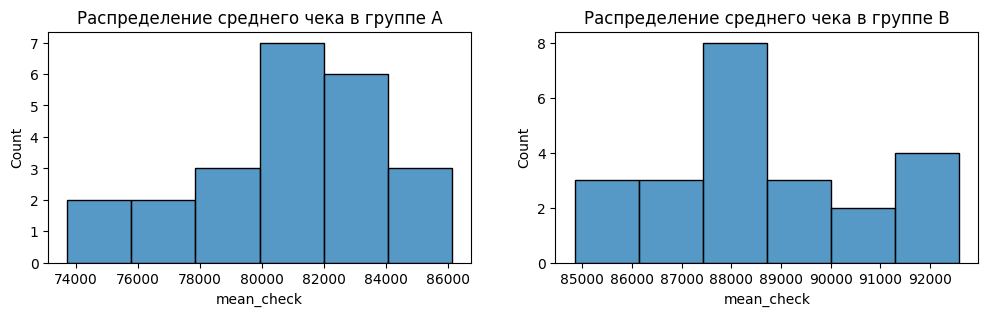

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check', data=daily_data.query("group == 'A'"), ax=axes[0])
sns.histplot(x='mean_check', data=daily_data.query("group == 'B'"), ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

Видимо, тут без Шапиро-Уилка не разберешься.

In [18]:
from scipy.stats import shapiro

alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(daily_data.query("group == 'A'")['mean_check'])
shapiro_result_b = shapiro(daily_data.query("group == 'B'")['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Удивительно. А для нормального распределения у нас есть t-тест!

In [19]:
from scipy.stats import ttest_ind

alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data.query("group == 'A'")['mean_check'],
    b=daily_data.query("group == 'B'")['mean_check'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Однако это не все, мы узнали заключение теста лишь о том, что распределения не равны друг другу. У нас появился повод уточнить гипотезы:
* Нулевая: распределение, лежащее в основе среднего чека в группе `A`, статистически больше либо равно распределению, лежащему в основе среднего чека в группе `B`. $$H_0: F_a(u) \geq F_b(u)$$
* Альтернативная: распределение, лежащее в основе среднего чека в группе `А`, статистически меньше распределения, лежащего в основе среднего чека в группе `B`: $$H_1: F_a(u) < F_b(u)$$

In [22]:
from scipy.stats import ttest_ind

alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data.query("group == 'A'")['mean_check'],
    b=daily_data.query("group == 'B'")['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Итак, решено: распределение среднего чека в группе `B` больше, чем в группе `A`.

Подкрепим результаты статистических тестов, построив 95 % доверительные интервалы для:
* конверсий в каждой из групп;
* разницы конверсий в группах;
* ежедневного среднего чека в каждой из групп.

Сперва рассчитаем доверительные интервалы для конверсий в группах.

In [57]:
from statsmodels.stats import proportion

# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=data.query("group == 'A'")['purchase'].sum(),
    nobs=data.query("group == 'A'")['user_id'].count(),
    alpha=0.05
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=data.query("group == 'B'")['purchase'].sum(),
    nobs=data.query("group == 'B'")['user_id'].count(),
    alpha=0.05
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format(
    (round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format(
    (round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


Мы получили пересечение интервалов. Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть. Т.е. мы не можем однозначно сказать, есть ли разница в конверсиях. Ситуация станет более определенной, когда мы рассчитаем разницу конверсий.

Воспользуемся функцией diff_proportion_conf_interval() от наших друзей со следующими аргументами: `x_p` — список из выборочных пропорций для групп `А` и `B` соответственно,  `n` — список из размеров выборки для групп `А` и `B`соответственно, и `gamma` — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [51]:
from scipy.stats import norm

def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [55]:
# размеры выборок групп А и B
n = [
    data.query("group == 'A'")['user_id'].count(),
    data.query("group == 'B'")['user_id'].count()
]
# выборочная пропорция групп A и B
x_p = [
    data.query("group == 'A'")['purchase'].mean(),
    data.query("group == 'B'")['purchase'].mean()
]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format(
    (round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Наш интервал охватывает точку 0, а значит, статистической разницы в конверсии между группами не имеется — они равнозначны.

Осталось рассчитать доверительные интервалы для ежедневного среднего чека в каждой из групп.

In [62]:
# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=daily_data.query("group == 'A'")['mean_check'].mean(),
    nobs=daily_data.query("group == 'A'")['users_count'].sum(),
    alpha=0.05
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=daily_data.query("group == 'B'")['mean_check'].mean(),
    nobs=daily_data.query("group == 'B'")['users_count'].sum(),
    alpha=0.05
)
# выводим результат
print('Доверительный интервал для ежедневного среднего чека в группе А: {}'.format(
    (round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для ежедневного среднего чека в группе B: {}'.format(
    (round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для ежедневного среднего чека в группе А: (55.47, 55.98)
Доверительный интервал для ежедневного среднего чека в группе B: (60.68, 61.18)


Доверительные интервалы не пересекаются, а это говорит о том, что истинное значение ежедневного среднего чека в обеих группах совпасть не может.

---
## Вывод

Мы проанализировали эффективность обоих вариантов посадочной страницы по двум критериям — конверсии покупки и ежедневному среднему чеку. Убедились, что A/B-тестирование было проведено корректно, проверили факт стабилизации метрик и, воспользовавшись статистическими тестами, установили: вариант `B` посадочной страницы более предпочтителен по метрике ежедневного среднего чека, а по метрике конверсии между вариантами `A` и `B` статистически значимая разница не определяется.

Вероятное объяснение преимущества `B`-версии: смещение предпочтений клиентов в пользу более дорогого тура.